In [10]:
# Imports
import math
import random

from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import PIL
import pyvista as pv
import torch

from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement
from vtk import vtkMatrix4x4, vtkMatrix3x3

from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import GaussianModel
from scene.cameras import Camera
from scene.dataset_readers import fetchPly
from utils.general_utils import PILtoTorch

In [11]:
# Setup some basic args without actually passing input
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument("--ip", type=str, default="127.0.0.1")
parser.add_argument("--port", type=int, default=6009)
parser.add_argument("--debug_from", type=int, default=-1)
parser.add_argument("--detect_anomaly", action="store_true", default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[])
parser.add_argument("--start_checkpoint", type=str, default=None)
args = parser.parse_args("")
args.save_iterations.append(args.iterations)

dataset = lp.extract(args)
training_args = op.extract(args)
pipe = pp.extract(args)
pipe.debug = True

In [12]:
# Load a .ply dataset as a Gaussian model
sh_degree = 3
gaussians = GaussianModel(sh_degree)

ply_path = "data/tooth.ply"
pcd = fetchPly(ply_path)

spatial_lr_scale = 4.982904243469239
gaussians.create_from_pcd(pcd, spatial_lr_scale)

gaussians.training_setup(training_args)

Number of points at initialisation :  64246


In [13]:
def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))


def focal2fov(focal, pixels):
    return 2 * math.atan(pixels / (2 * focal))

In [14]:
# Instantiate the plotter once
def init_pv_plotter(path, width, height):
    mesh = pv.read(path)
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(mesh, show_scalar_bar=False, cmap=plt.cm.coolwarm_r)
    plotter.window_size = [width, height]
    plotter.camera.up = (0, 0, 1)
    return plotter


# Just used for getting the VTK matrices into a ndarray
def arrayFromVTKMatrix(vmatrix):
    if isinstance(vmatrix, vtkMatrix4x4):
        matrixSize = 4
    elif isinstance(vmatrix, vtkMatrix3x3):
        matrixSize = 3
    else:
        raise RuntimeError("Input must be vtk.vtkMatrix3x3 or vtk.vtkMatrix4x4")
    narray = np.eye(matrixSize)
    vmatrix.DeepCopy(narray.ravel(), vmatrix)
    return np.round(narray, 4).astype(np.float32)


# Generates a new Camera() object
def get_new_vtk_camera(plotter, seed):
    np.random.seed(seed)

    camera = plotter.camera

    # Set a new random camera position along a sphere centered on the model
    current_position = np.array(camera.position)
    focal_point = np.array(camera.focal_point)

    radius = np.linalg.norm(current_position - focal_point)
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)

    x = focal_point[0] + radius * np.sin(theta) * np.cos(phi)
    y = focal_point[1] + radius * np.sin(theta) * np.sin(phi)
    z = focal_point[2] + radius * np.cos(theta)
    camera.position = (x, y, z)
    # camera.position = (1.1, 2.2, 3.3)
    # camera.focal_point = (0, 0, 0)

    # Render the model, convert it to a PIL Image
    image_array = PIL.Image.fromarray(plotter.screenshot(return_img=True))
    # image_array = PIL.Image.fromarray(plotter.screenshot(return_img=True)).transpose(
    #     PIL.Image.FLIP_TOP_BOTTOM
    # )

    resized_image_rgb = PILtoTorch(image_array, image_array.size, "cuda")
    gt_image = resized_image_rgb[:3, ...]

    loaded_mask = None
    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    mvt_matrix = np.linalg.inv(arrayFromVTKMatrix(camera.GetModelViewTransformMatrix()))
    print(f"mvt_matrix={mvt_matrix}")
    # mvt_matrix = np.linalg.inv(mvt_matrix)
    # mvt_matrix[:3, 0] *= -1
    # mvt_matrix[:3, 1] *= -1
    # mvt_matrix[:3, 2] *= -1
    # mvt_matrix = np.linalg.inv(mvt_matrix)

    rotation = mvt_matrix[:3, :3].T
    translation = mvt_matrix[:3, 3]

    width, height = plotter.window_size
    # FovX = np.radians(camera.view_angle)
    # FovY = focal2fov(fov2focal(FovX, width), height)
    FovY = np.radians(camera.view_angle)
    FovX = focal2fov(fov2focal(FovY, height), width)

    proj_matrix = arrayFromVTKMatrix(
        camera.GetCompositeProjectionTransformMatrix(width / height, 0.01, 1000.01)
    )
    # proj_matrix[:3, 0] *= -1
    # proj_matrix[:3, 1] *= -1
    # proj_matrix[:3, 2] *= -1
    # proj_matrix = np.linalg.inv(proj_matrix)
    # proj_matrix[:3, 0] *= -1
    # proj_matrix[:3, 1] *= -1
    # proj_matrix[:3, 2] *= -1
    # proj_matrix = np.linalg.inv(proj_matrix)

    cx = 0
    cy = 0

    plotter.close()

    # Instantiate a new Camera object using these computed values
    new_camera = Camera(
        colmap_id=1,
        R=rotation,
        T=translation,
        FoVx=FovX,
        FoVy=FovY,
        cx=cx,
        cy=cy,
        image=gt_image,
        gt_alpha_mask=loaded_mask,
        image_name="",
        uid=0,
        data_device="cuda",
    )
    print(f"proj_matrix={proj_matrix}")
    # proj_matrix[1, :] = -proj_matrix[1, :]
    # proj_matrix[2, :] = -proj_matrix[2, :]
    new_camera.from_vtk(mvt_matrix, proj_matrix, camera.position)

    # Debug prints

    # print("new_camera")
    # print(f"azimuth={azimuth}")
    # print(f"elevation={elevation}")
    # print(f"roll={roll}")
    print(f"view_angle={camera.view_angle}")
    print(f"orientation={camera.GetOrientation()}")
    print(f"orientationWXYZ={camera.GetOrientationWXYZ()}")
    # print(f"uid={new_camera.uid}")
    # print(f"colmap_id={new_camera.colmap_id}")
    # print(f"R={new_camera.R}")
    # print(f"T={new_camera.T}")
    print(
        f"modelview={np.linalg.inv(arrayFromVTKMatrix(camera.GetModelViewTransformMatrix()))}"
    )
    print(f"eye={arrayFromVTKMatrix(camera.GetEyeTransformMatrix())}")
    print(f"mvt_matrix={mvt_matrix.T}")
    print(f"proj_matrix={proj_matrix}")
    # print(f"FoVx={new_camera.FoVx}")
    # print(f"FoVy={new_camera.FoVy}")
    # print(f"cx={new_camera.cx}")
    # print(f"cy={new_camera.cy}")
    # print(f"image_name={new_camera.image_name}")
    # print(f"data_device={new_camera.data_device}")
    # print(f"image_width={new_camera.image_width}")
    # print(f"image_height={new_camera.image_height}")
    # print(f"zfar={new_camera.zfar}")
    # print(f"znear={new_camera.znear}")
    # print(f"trans={new_camera.trans}")
    # print(f"scale={new_camera.scale}")
    print(f"world_view_transform={new_camera.world_view_transform}")
    print(f"projection_matrix={new_camera.projection_matrix}")
    print(f"full_proj_transform={new_camera.full_proj_transform}")
    print(f"camera_center={new_camera.camera_center}")
    print(f"position={camera.position}")
    print(f"focal_point={camera.focal_point}")
    # print(f"focal_disk={camera.GetFocalDisk()}")
    # print(f"view_up={camera.up}")
    print(f"direction={camera.direction}")
    # print(f"window_center={camera.GetWindowCenter()}")
    return new_camera

mvt_matrix=[[-1.1488591e-01  7.8784835e-01 -6.0506672e-01 -1.7701724e+02]
 [-9.9336737e-01 -9.1045894e-02  6.9923155e-02  7.2825531e+01]
 [ 3.7495745e-05  6.0902977e-01  7.9314083e-01  3.8034558e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
proj_matrix=[[-4.286000e-01 -3.707400e+00  0.000000e+00  1.941537e+02]
 [ 2.940300e+00 -3.399000e-01  2.273100e+00 -3.193226e+02]
 [ 8.824713e+02 -1.020245e+02 -1.156762e+03  3.233911e+05]
 [ 6.050000e-01 -7.000000e-02 -7.931000e-01  4.138453e+02]]
view_angle=30.0
orientation=(4.011173618384102, 37.33930801453773, 95.23898728514872)
orientationWXYZ=(101.912164140335, -0.2754964700213544, 0.30918230712040823, 0.9102241460044193)
modelview=[[-1.1488591e-01  7.8784835e-01 -6.0506672e-01 -1.7701724e+02]
 [-9.9336737e-01 -9.1045894e-02  6.9923155e-02  7.2825531e+01]
 [ 3.7495745e-05  6.0902977e-01  7.9314083e-01  3.8034558e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
eye=[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0.

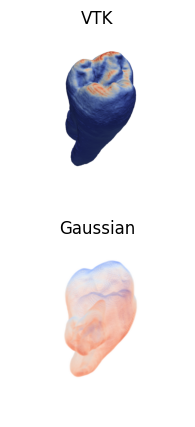

In [18]:
# Generate a new synthetic viewpoint and feed the camera parameters to the Gaussian renderer
bg_color = [1, 1, 1]
bg = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Can change the image resolution to whatever you'd like, but 1080p is fast
width = 800
height = 800

plotter = init_pv_plotter(ply_path, width, height)

# Seeded random camera values, was supposed to help with debugging
seed = 22

viewpoint_cam = get_new_vtk_camera(plotter, seed)
render_pkg = render(viewpoint_cam, gaussians, pipe, bg)
gaussian_image = render_pkg["render"]

# Original Pyvista render (ground truth)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(viewpoint_cam.original_image.cpu().detach().numpy().transpose(1, 2, 0))
axes[0].set_title("VTK")
axes[0].axis("off")

# Gaussian render (usually the model isn't in the scene)
axes[1].imshow(gaussian_image.cpu().detach().numpy().transpose(1, 2, 0))
axes[1].set_title("Gaussian")
axes[1].axis("off")
plt.show()

In [16]:
def getProjectionMatrix(fovy, aspect, zNear, zFar):
    tanHalfFovy = math.tan((fovy / 2.0))

    p_matrix = torch.zeros(4, 4)
    p_matrix[0, 0] = 1.0 / (aspect * tanHalfFovy)
    p_matrix[1, 1] = 1.0 / tanHalfFovy
    p_matrix[2, 2] = (zFar + zNear) / (zFar - zNear)
    p_matrix[2, 3] = 1.0
    p_matrix[3, 2] = -(2.0 * zFar * zNear) / (zFar - zNear)
    return p_matrix


print(getProjectionMatrix(math.radians(30.0), width / height, 0.1, 100.0))

tensor([[ 3.7321,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.7321,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0020,  1.0000],
        [ 0.0000,  0.0000, -0.2002,  0.0000]])


In [17]:
from turtle import pos


def getWorld2View2(R, t):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R
    Rt[3, :3] = -t
    Rt[3, 3] = 1.0
    return np.float32(Rt)


def lookAt(eye, center, up):
    f = np.array(center - eye)
    s = np.cross(f, up)
    u = np.cross(s, f)

    view_mat = np.zeros((4, 4))
    view_mat[0][0] = s[0]
    view_mat[1][0] = s[1]
    view_mat[2][0] = s[2]
    view_mat[0][1] = u[0]
    view_mat[1][1] = u[1]
    view_mat[2][1] = u[2]
    view_mat[0][2] = -f[0]
    view_mat[1][2] = -f[1]
    view_mat[2][2] = -f[2]
    view_mat[3][0] = -np.dot(s, eye)
    view_mat[3][1] = -np.dot(u, eye)
    view_mat[3][2] = np.dot(f, eye)
    return view_mat


yaw = -90.0
pitch = 0.0
rotation = np.array([[1.0, 0.0, -0.0], [-0.0, 1.0, -0.0], [0.0, 0.0, 1.0]])
position = np.array([1.1, 2.2, 3.3])
up = np.array([0.0, 1.0, 0.0])
x = math.cos(math.radians(yaw)) * math.cos(math.radians(pitch))
y = math.sin(math.radians(pitch))
z = math.sin(math.radians(yaw)) * math.cos(math.radians(pitch))
front = np.array([x, y, z])
front = front / math.sqrt(np.dot(front, front))
right = np.cross(front, up)
right = right / math.sqrt(np.dot(right, right))
up = np.cross(right, front)
up = up / math.sqrt(np.dot(up, up))

print(f"position={position}")
print(f"front={front}")
print(f"right={right}")
print(f"up={up}")
# print(getWorld2View2(rotation, position))
print(lookAt(position, position + front, up))

position=[1.1 2.2 3.3]
front=[ 6.123234e-17  0.000000e+00 -1.000000e+00]
right=[ 1.000000e+00 -0.000000e+00  6.123234e-17]
up=[0. 1. 0.]
[[ 1.   0.  -0.   0. ]
 [-0.   1.  -0.   0. ]
 [ 0.   0.   1.   0. ]
 [-1.1 -2.2 -3.3  0. ]]
